# Fault diagnosis in a tank system using a Kalman filter
## Tutorial
The Kalman filter can be used to detect faults in engineering equipment (sensors and actuators).
In this tutorial you will learn to use the Kalman filter to diagnose fault in a quadruple tank system.

In [316]:
# import the necessary libraries
import math
import random
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

## Case study description

### General description

The *quadruple tank system* shown below consists of four tanks coupled to a rig. At the bottom we have two submersible  pumps.  The  water is pumped to the top tanks (tank 1 and tank 3) from the reservoir where the pumps are submerged.

The two pumps are independently  controlled in order to supply water to the top tanks. The pumps work by being supplied internally with voltage derived from the coupled  tanks. The top tanks (tanks 1 and 3) are coupled to each other, tank 2 and tank 4 are not considered in this study. The water from the upper tanks just goes into tanks 2 and 4.


<center><img text-align="center" alt="Quadruple tank system" src="imgs\quadruple_tank.png" width="400"/></center>


### First principles

The dynamic behavior of tank 1 and 3 is given by the equations below which are obtained from first principles laws. The equations of the two tanks are as follows:

\begin{eqnarray}
\dot{h_1} = \frac{u_1 \beta}{A} - k_{v1} h_1 - k_{v13}h_1 + k_{v13}h_3\\
\dot{h_3} = \frac{u_2 \beta}{A} - k_{v3} h_3 - k_{v13}h_3 + k_{v13}h_1
\end{eqnarray}

where
$k_{v1} = \sqrt{2g}(\frac{a_1}{A})$
$k_{v3} = \sqrt{2g}(\frac{a_3}{A})$
$k_{v13} = \sqrt{2g}(a_{13})$
$A$ is the cross sectional area of each tank (cm$^2$)
$a_1$ is the outlet area of tank 1 (cm$^2$)
$a_3$ is the outlet area of tank 3 (cm$^2$)
$a_{13}$ is the outlet area of tank 1 and tank 3 (cm$^2$)
$h_1, h_3$ is the water level height in tank 1 and tank 3 respectively (cm)
$u_1, u_2$ is the pump voltage going to tank 1 and tank 3 respectively (volts)
$\beta$ is the constant relating the control voltage with the water flow from the pump

where we it is known that:
$A = 0.01389 (cm$^2$) $
$a_1, a_3, a_{13} = 50.265 * 10^{-6} (cm$^2$)$
$g = 9.81*10^{-2} (cm/s)$
$\beta = 2.2 * 10^{-3}$
$k_{v1}, k_{v3} = 1.6 * 10^{-2}$
$k_{v13} = 2.2264 * 10^{-4}$

More information about the constants and system can be found at:

Gomathi, V., et al. "Fault diagnosis in a quadruple tank system using Kalman filter." 2017 International Conference on Computation of Power, Energy Information and Commuincation (ICCPEIC). IEEE, 2017.

### State space representation of the tank system
The state space representation of the coupled tank system is as follows:
$$\begin{bmatrix} \dot{h_1} \\ \dot{h_3} \end{bmatrix} = \begin{bmatrix} (-k_{v1} - k_{v13}) & k_{v13} \\ k_{v13} & (-k_{v3} - k_{v13}) \end{bmatrix} \begin{bmatrix} h_1 \\ h_3 \end{bmatrix}  + \begin{bmatrix} \beta/A & 0 \\ 0 & \beta/A \end{bmatrix} \begin{bmatrix} {u_1} \\ {u_2} \end{bmatrix} $$
$$\begin{bmatrix} {y_1} \\ {y_3} \end{bmatrix} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} h_1 \\ h_3 \end{bmatrix}
$$


### Generate the real dynamics of the system
You should generate a voltage for both sides of the tank system ($u_1 = u_2$)

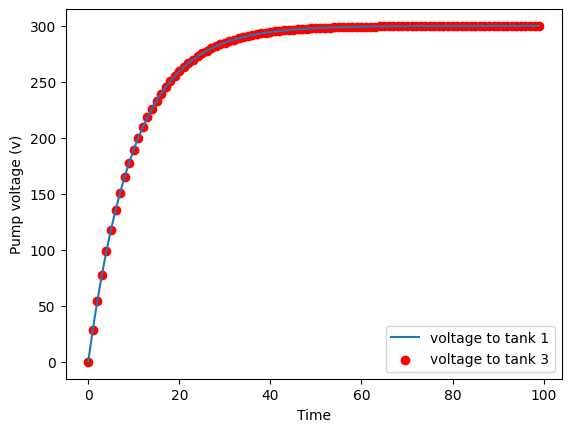

In [336]:
# generate the voltage in the reservoir tank (for both pump 1 and 2)
def generate_voltage(n_samples):
    voltage = []
    for t in range(n_samples):
        a_true = 300
        volt = a_true - a_true * math.exp(-0.1 * t)
        voltage.append(volt)
    return voltage

voltage_tank = generate_voltage(n_samples=100)

# plot the voltage over time (for each tank side)
plt.plot(voltage_tank, label='voltage to tank 1')
plt.scatter(range(len(voltage_tank)), voltage_tank, label='voltage to tank 3', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pump voltage (v)')
plt.show()

### Generate the real dynamics of the system
Based on the voltage for both sides of the tank system ($u_1 = u_2$), you can now generate a "realistic" water level (for tank 1 and tank 3) based on the first principles given.


In [337]:
# function to generate the water level of each tank over time based on the voltage and the equations
def generate_water_level(voltage):
    water_level_1 = []
    water_level_3 = []
    h_1 = 0
    h_3 = 0
    beta = 2.2 * math.pow(10, -3)
    A = 0.01389
    k_v1 = 1.6 * math.pow(10, -2)
    k_v3 = 1.6 * math.pow(10, -2)
    k_v13 = 2.2264 * math.pow(10, -4)

    for volt in voltage:
        h_1 = ((volt * beta) / A) - k_v1 * h_1 - k_v13 * h_1 + k_v13 * h_3
        h_3 = ((volt * beta) / A) - k_v3 * h_3 - k_v13 * h_3 + k_v13 * h_1
        water_level_1.append(h_1)
        water_level_3.append(h_3)

    return water_level_tank1, water_level_tank3

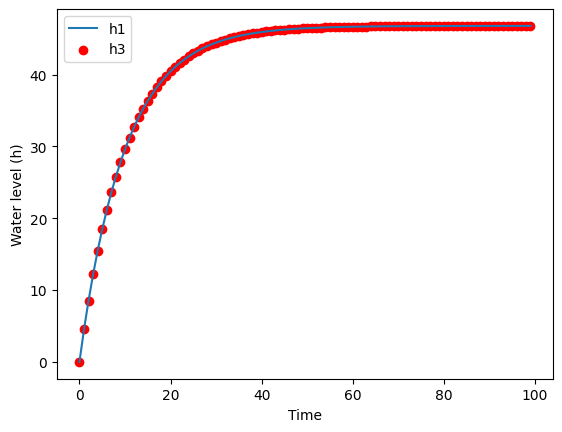

In [338]:
# generate actual water level trajectories of each tank
water_level_tank1, water_level_tank3 = generate_water_level(voltage_tank)

# plot the water level trajectories
plt.plot(water_level_tank1, label='h1')
plt.scatter(range(len(water_level_tank3)), water_level_tank3, color='red', label='h3')
plt.xlabel('Time')
plt.ylabel('Water level (h)')
plt.legend()
plt.show()

### Add noise to the real dynamics of the system
Add noise to the water level of tank 1 and tank3.

In [339]:
# function to add Gaussian noise to an array of data according to a standard deviation
def add_noise_data(data, sigma):
    noisy_data = []
    for t in range(len(data)):
        elm = data[t] + random.gauss(mu=0, sigma=sigma)
        noisy_data.append(elm)
    return noisy_data

In [342]:
# add the noise to both tanks (water levels) with a sigma of 0.2
water_level_1_noisy = add_noise_data(water_level_tank1, 0.2)
water_level_3_noisy = add_noise_data(water_level_tank3, 0.2)

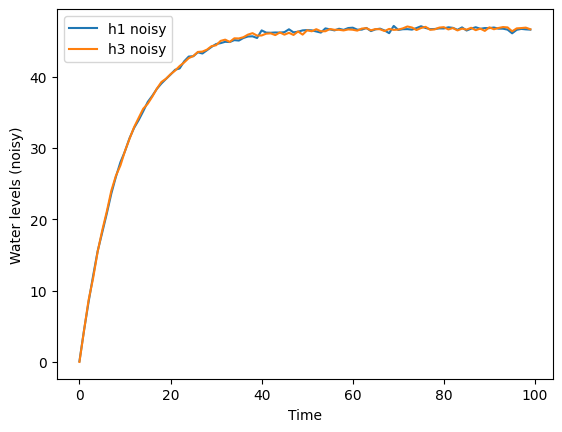

In [344]:
plt.plot(water_level_1_noisy, label='h1 noisy')
plt.plot(water_level_3_noisy, label='h3 noisy')
plt.xlabel('Time')
plt.ylabel('Water levels (noisy)')
plt.legend()
plt.show()

### Create a state space system to track the system dynamics

Create a Kalman filter (the system is linear) to track the h1 and h3 over time.

In [351]:
# First construct the Kalman filter object with the required dimensionality.
f = KalmanFilter(dim_x=2, dim_z=2)
h1_0 = 0
h2_0 = 0
k_v1 = 1.6 * math.pow(10, -2)
k_v3 = 1.6 * math.pow(10, -2)
k_v13 = 2.2264 * math.pow(10, -4)
beta = 2.2 * math.pow(10, -3)
A = 0.01389
# Assign the initial value for the state
f.x = np.array([[h1_0],   # damage state x
                [h2_0]])  # standard deviation of measurement error s
# define the state transition matrix
f.F = np.array([[-(k_v1 + k_v13), k_v13],
                [k_v13,  -(k_v3 + k_v13)]])
# define the control-input matrix
f.B = np.array([[beta/A, 0],
                [0, beta/A]])
# define the measurement function/ observation matrix
f.H = np.array([[1, 0],
                [0, 1]])
# define the covariance matrix (follow the system perfectly)
f.P = np.array([[0, 0], [0, 0]])

# Measurement noise
f.R = 0.00001 # np.array([[100, 0], [0, 0.01]])
# Process noise
f.Q = 0 #np.array([[0], [0]]) # np.array([[0.15838, 0], [0, 0.15838]])

# Put the kalman filter to run
estimates_water_level_1, estimates_water_level_3 = [], []
for t in range(len(voltage_tank)):
    u = [[voltage_tank[t]],
         [voltage_tank[t]]]
    z = [[water_level_1_noisy[t]],
         [water_level_3_noisy[t]]]
    f.predict(u)
    f.update(z)
    estimates_water_level_1.append(f.x[0])
    estimates_water_level_3.append(f.x[1])

print('Done estimating')

Done estimating


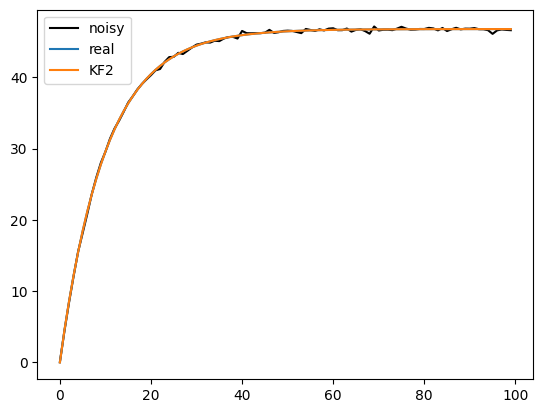

In [346]:
plt.plot(range(len(water_level_1_noisy)), water_level_1_noisy, c='black', label='noisy')
plt.plot(range(len(water_level_tank1)), water_level_tank1, label='real')
plt.plot(range(len(estimates_water_level_1)), estimates_water_level_1, label='KF2')
plt.legend()
plt.show()

In [308]:
def generate_water_level_with_additive_failure(n_samples, failure_range):
    water_level_tank1_with_failure = []
    water_level_tank3_with_failure = []
    voltage = []
    h_1 = 0
    h_3 = 0
    beta = 2.2 * math.pow(10, -3)
    A = 0.01389
    k_v1 = 1.6 * math.pow(10, -2)
    k_v3 = 1.6 * math.pow(10, -2)
    k_v13 = 2.2264 * math.pow(10, -4)

    for t in range(n_samples):
        a_true = 300
        fault = 0
        if t in failure_range:
            fault = a_true * 0.01
        volt = a_true - a_true * math.exp(-0.1 * t)
        h_1 = ((volt * beta) / A) - k_v1 * h_1 - k_v13 * h_1 + k_v13 * h_3 + fault
        h_3 = ((volt * beta) / A) - k_v3 * h_3 - k_v13 * h_3 + k_v13 * h_1
        water_level_tank1_with_failure.append(h_1)
        water_level_tank3_with_failure.append(h_3)
        voltage.append(volt)

    return water_level_tank1_with_failure, water_level_tank3_with_failure, voltage

In [297]:
water_level_tank1_with_failure, water_level_tank3_with_failure, voltage = generate_water_level_with_additive_failure(n_samples=100, failure_range =range(24, 60))

water_level_tank1_with_failure_noisy = add_noise_data(water_level_tank1_with_failure, 0.2)
water_level_tank3_with_failure_noisy = add_noise_data(water_level_tank3_with_failure, 0.2)

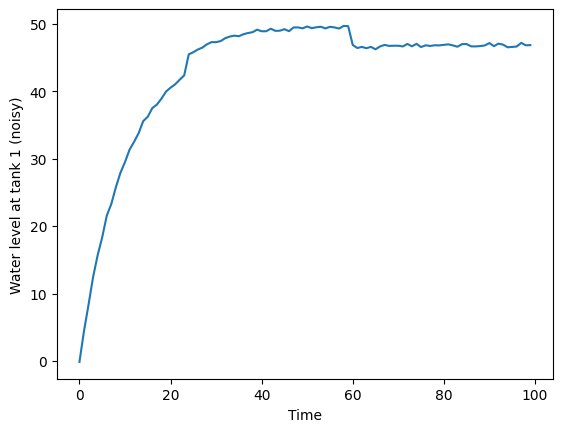

In [298]:
plt.plot(water_level_tank1_with_failure_noisy)
plt.xlabel('Time')
plt.ylabel('Water level at tank 1 (noisy)')
plt.show()

In [304]:
estimates_water_level_1_additive_failure, estimates_water_level_3_additive_failure = [], []
residuals = []
for t in range(len(voltage)):
    u = [[voltage[t]],
         [voltage[t]]]
    z = [[water_level_tank1_with_failure_noisy[t]],
         [water_level_tank3_with_failure_noisy[t]]]
    f.predict(u)
    f.update(z)
    estimates_water_level_1_additive_failure.append(f.x[0])
    estimates_water_level_3_additive_failure.append(f.x[1])
    residuals.append(f.x[0] - water_level_tank1_with_failure_noisy[t])

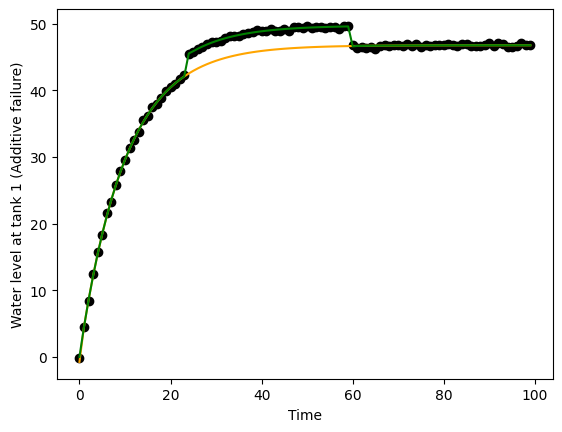

In [303]:
plt.plot(estimates_water_level_1_additive_failure, label='estimated water level', color='orange')
plt.plot(water_level_tank1_with_failure, label='true water level', color='green')
plt.scatter(range(len(water_level_tank1_with_failure_noisy)), water_level_tank1_with_failure_noisy, label='noisy true water level', color='black')
plt.xlabel('Time')
plt.ylabel('Water level at tank 1 (Additive failure)')
plt.show()

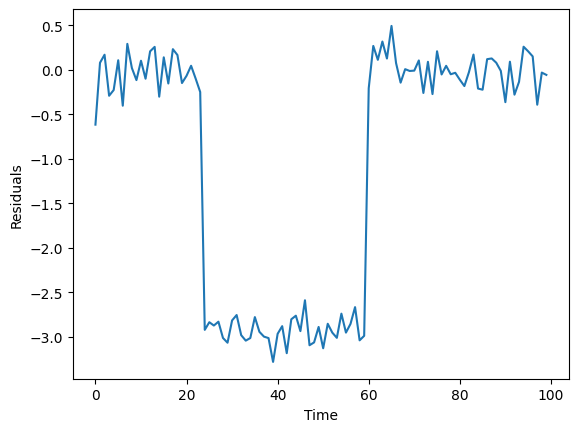

In [306]:
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()